# Importing all necessary files

In [4]:
import glob
import os
import librosa
import re
import numpy as np
import math
import AlexNet_ArchModifiedFull
librosa.util.MAX_MEM_BLOCK = 262144/4
from torch.autograd import Variable
import torch
import numpy as np
from scipy import misc
from scipy import signal
import torch.optim as optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
print(torch.__version__)
import torch.cuda
from sklearn import metrics
import matplotlib.pyplot as plt
import itertools
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale

0.3.1.post2


In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = 100*cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
Labels = ["dog","rooster","pig","cow","frog","cat","hen","insects","sheep","crow"
         "rain","sea_waves","crackling_fire","crickets","chirping_birds","water_drops"
         "wind","pouring_water","toilet_flush","thunderstorm","crying_baby",
         "sneezing","clapping","breathing","coughing","footsteps","laughing",
         "brushing_teeth","snoring","drinking_sipping","door_wood_knock",
         "mouse_click","keyboard_typing","door_wood_creaks","can_opening",
         "washing_machine","vacuum_cleaner","clock_alarm","clock_tick",
         "glass_breaking","helicopter","chainsaw","siren","car_horn",
         "engine","train","church_bells","airplane","fireworks","hand_saw"]


In [6]:
sr = 16000
dataSetDir = "ESC-50-master//audio"

In [7]:
def load_sounds_mfcc_format(dataSetDir,sr):
    mfccs = []
    mfccs_mean = []
    labels = []
    j = 0
    names = []
    datasetSize = len(os.listdir(dataSetDir))

    for file in sorted(os.listdir(dataSetDir)):
        # sound is the audio time-series and the sampling rate of the time-series is set to be the default
        # 22050 samples per second
        j = j + 1
        sound,sr = librosa.load(dataSetDir+"//"+file,sr = sr)
        mfcc = (librosa.feature.mfcc(y=sound, sr=sr, n_mfcc=40))
        mfcc_mean = np.mean((mfcc).T,axis=0)
        mfccs.append(mfcc.reshape(mfcc.shape[0]*mfcc.shape[1]))
        mfccs_mean.append(mfcc_mean)
        #extracting the label
        label = re.findall(r'\d+\.wav$',file)
        names.append(file)
        labels.append(int((label[0][:-4])))
        if j % 100 == 99:
            
            print(str(j+1) + " audio samples extracted: Progress = " + 
                  str((j+1)/datasetSize * 100) +  "%" )
      
    return names,np.asarray(mfccs), labels

dataSetDir = "ESC-50-master//audio"



In [8]:
names1, mfccs, labelSet = load_sounds_mfcc_format(dataSetDir,sr=sr)
np.save("mfccs",mfccs)

100 audio samples extracted: Progress = 5.0%
200 audio samples extracted: Progress = 10.0%
300 audio samples extracted: Progress = 15.0%
400 audio samples extracted: Progress = 20.0%
500 audio samples extracted: Progress = 25.0%
600 audio samples extracted: Progress = 30.0%
700 audio samples extracted: Progress = 35.0%
800 audio samples extracted: Progress = 40.0%
900 audio samples extracted: Progress = 45.0%
1000 audio samples extracted: Progress = 50.0%
1100 audio samples extracted: Progress = 55.00000000000001%
1200 audio samples extracted: Progress = 60.0%
1300 audio samples extracted: Progress = 65.0%
1400 audio samples extracted: Progress = 70.0%
1500 audio samples extracted: Progress = 75.0%
1600 audio samples extracted: Progress = 80.0%
1700 audio samples extracted: Progress = 85.0%
1800 audio samples extracted: Progress = 90.0%
1900 audio samples extracted: Progress = 95.0%
2000 audio samples extracted: Progress = 100.0%


In [31]:
mfccs = np.load("mfccs.npy")
scaler = StandardScaler()
mfccs = scaler.fit_transform(mfccs)

# Initializing an AlexNet instance

In [32]:
audioNet = AlexNet_ArchModifiedFull.model()
print(audioNet)

AlexNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=18824, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_feat

# Defining optimizer parameters

In [33]:
criterion = nn.CrossEntropyLoss(size_average=False)
optimizer = torch.optim.SGD(audioNet.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.90)

# Setting frame length and the sampling rate

In [34]:
frameLength = 40 * 1e-3
sr = 16000

In [35]:
dataSetDir = str(sr/1e3) + "KHz_framelength" + str(frameLength*1e3)

In [36]:
print(dataSetDir)

16.0KHz_framelength40.0


In [37]:
def load_spectrogramImages(dataSetDir):
    """
    This function loads the spectogram images from the dataset dir and
    also extracts the labels
    """
    spectograms = []
    names = []
    labels = []
    i = 0
    for file in sorted(os.listdir(dataSetDir)):
        spectogram = misc.imread(dataSetDir+"//"+file)
        spectograms.append(spectogram)
        names.append(file[:-9])
        i = i +1
        
        #extracting the label
        label = re.findall(r'(\d+)(?!.*\d)',file) 
        labels.append(int(label[0]))
 
        
    return np.asarray(spectograms),names,np.asarray(labels)

In [38]:
spectograms, names, labels = load_spectrogramImages(dataSetDir)


In [39]:
print(len(spectograms))
print((mfccs[99]))

2000
[ 0.83  0.97  1.16 ...,  0.08 -0.42 -0.36]


In [40]:
print(len(labels))

2000


# Dividing into train and test-set

In [41]:
num = 9*len(spectograms)//10
print("The train-set size is " + str(num))
print("The test-set size is " + str(len(spectograms)- num))
spectTest = []
labelTest = []
mfccTest = []

for i in range(len(spectograms[num:])):
    labelTest.append(labels[num+i])
    spectTest.append(spectograms[num+i])
    mfccTest.append(mfccs[num+i])

The train-set size is 1800
The test-set size is 200


In [42]:
train_index = [i for i in range(0,num)]
test_index = [i for i in range(num,len(spectograms))]
print(train_index)
print(test_index)
train_index = torch.from_numpy(np.array(train_index))
test_index = torch.from_numpy(np.array(test_index))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [43]:
spectograms = torch.from_numpy(spectograms)
spectograms = spectograms.float()
mfccs = torch.from_numpy(mfccs)
mfccs = mfccs.float()
labels = torch.from_numpy(np.asarray(labels))
spectTest = torch.from_numpy(np.asarray(spectTest))
labelTest = torch.from_numpy(np.asarray(labelTest))
mfccTest = torch.from_numpy(np.asarray(mfccTest))


In [44]:
print(spectograms[:num].shape)
trainset = torch.utils.data.TensorDataset(train_index, labels[:num])
testset = torch.utils.data.TensorDataset(test_index, labelTest)


torch.Size([1800, 256, 256])


In [45]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size = 200)

In [46]:
use_gpu = torch.cuda.is_available()
print(use_gpu)
if use_gpu == True:
    torch.cuda.set_device(2)
    audioNet.cuda()

True


In [47]:
def initializeWeights(layer):
    if isinstance(layer, nn.Conv2d):
        n = layer.kernel_size[0] * layer.kernel_size[1] * layer.out_channels
        layer.weight.data.normal_(0, math.sqrt(2. / n))
    elif isinstance(layer, nn.BatchNorm2d):
        layer.weight.data.fill_(1)
        layer.bias.data.zero_()

In [48]:
audioNet.apply(initializeWeights)

AlexNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=18824, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_feat

In [49]:
spectograms[1]


    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
       ...          ⋱          ...       
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 256x256]

In [50]:
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        indices, labels = data
        inputs = []
        mfcc_inputs = []
        for j in indices:
            inputs.append(spectograms[j])
            mfcc_inputs.append(mfccs[j])
        inputs = torch.stack(inputs)
        inputs = (inputs.float()).unsqueeze(1)
        mfcc_inputs = torch.stack(mfcc_inputs)
        mfcc_inputs = (mfcc_inputs.float()).unsqueeze(1)
        #print(inputs.shape)
        # wrap them in Variable
        #inputs, labels = Variable(inputs), Variable(labels)
        if use_gpu == True:
            inputs,mfcc, labels = Variable(inputs.cuda()), Variable(mfcc_inputs.cuda()), Variable(labels.cuda())
            
        else:
            inputs,mfcc, labels = Variable(inputs),Variable(mfcc_inputs), Variable(labels)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = audioNet(inputs,mfcc)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.data[0]
        if i % 5 == 4:    # print every 50 mini-batches
            print('[%d, %5d] loss: %.8f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    scheduler.step()
    correct = 0
    total = 0
    for data in testloader:
        indices, labels = data
        inputs = []
        mfcc_inputs = []
        for j in indices:
            inputs.append(spectograms[j])
            mfcc_inputs.append(mfccs[j])
        inputs = torch.stack(inputs)
        inputs = (inputs.float()).unsqueeze(1)
        mfcc_inputs = torch.stack(mfcc_inputs)
        mfcc_inputs = (mfcc_inputs.float()).unsqueeze(1)
        if use_gpu == True:
            outputs = audioNet(Variable(inputs.cuda()),Variable(mfcc_inputs.cuda()))
        else:
            outputs = audioNet(Variable(inputs),Variable(mfcc_inputs))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        if use_gpu == True:
            predicted = predicted.cpu()
        correct += (predicted == labels).sum()
        #print(predicted)
        #print(correct)
        
    print('Accuracy of the network on the 200 test images: %d %%' % (
        100 * correct / total))
print('Finished Training')

[1,     5] loss: 0.63159325
[1,    10] loss: 0.61355550
[1,    15] loss: 0.60706210
[1,    20] loss: 0.59116000
[1,    25] loss: 0.58381034
Accuracy of the network on the 200 test images: 10 %
[2,     5] loss: 0.53047896
[2,    10] loss: 0.51358464
[2,    15] loss: 0.49482980
[2,    20] loss: 0.48596752
[2,    25] loss: 0.47878743
Accuracy of the network on the 200 test images: 17 %
[3,     5] loss: 0.41442063
[3,    10] loss: 0.40821550
[3,    15] loss: 0.40484752
[3,    20] loss: 0.39469723
[3,    25] loss: 0.37543368
Accuracy of the network on the 200 test images: 17 %
[4,     5] loss: 0.33607320
[4,    10] loss: 0.31647437
[4,    15] loss: 0.30813060
[4,    20] loss: 0.30825840
[4,    25] loss: 0.30324797
Accuracy of the network on the 200 test images: 25 %
[5,     5] loss: 0.25637210
[5,    10] loss: 0.25218702
[5,    15] loss: 0.25680882
[5,    20] loss: 0.25059996
[5,    25] loss: 0.23802053
Accuracy of the network on the 200 test images: 31 %
[6,     5] loss: 0.19439806
[6,    

Accuracy of the network on the 200 test images: 43 %
[43,     5] loss: 0.01048863
[43,    10] loss: 0.01211062
[43,    15] loss: 0.01073969
[43,    20] loss: 0.00941831
[43,    25] loss: 0.00916103
Accuracy of the network on the 200 test images: 45 %
[44,     5] loss: 0.00903202
[44,    10] loss: 0.00912523
[44,    15] loss: 0.01120998
[44,    20] loss: 0.01060966
[44,    25] loss: 0.01052480
Accuracy of the network on the 200 test images: 38 %
[45,     5] loss: 0.00962340
[45,    10] loss: 0.01169757
[45,    15] loss: 0.00871226
[45,    20] loss: 0.00994170
[45,    25] loss: 0.01058571
Accuracy of the network on the 200 test images: 40 %
[46,     5] loss: 0.00912982
[46,    10] loss: 0.01031636
[46,    15] loss: 0.01070892
[46,    20] loss: 0.00986073
[46,    25] loss: 0.00927468
Accuracy of the network on the 200 test images: 43 %
[47,     5] loss: 0.01035382
[47,    10] loss: 0.00780134
[47,    15] loss: 0.01098037
[47,    20] loss: 0.01283600
[47,    25] loss: 0.00952243
Accuracy o

In [51]:
print('The final accuracy of the network on the 200 test images after training is: %d %%' % (
        100 * correct / total))

The final accuracy of the network on the 200 test images after training is: 43 %


Confusion matrix, without normalization


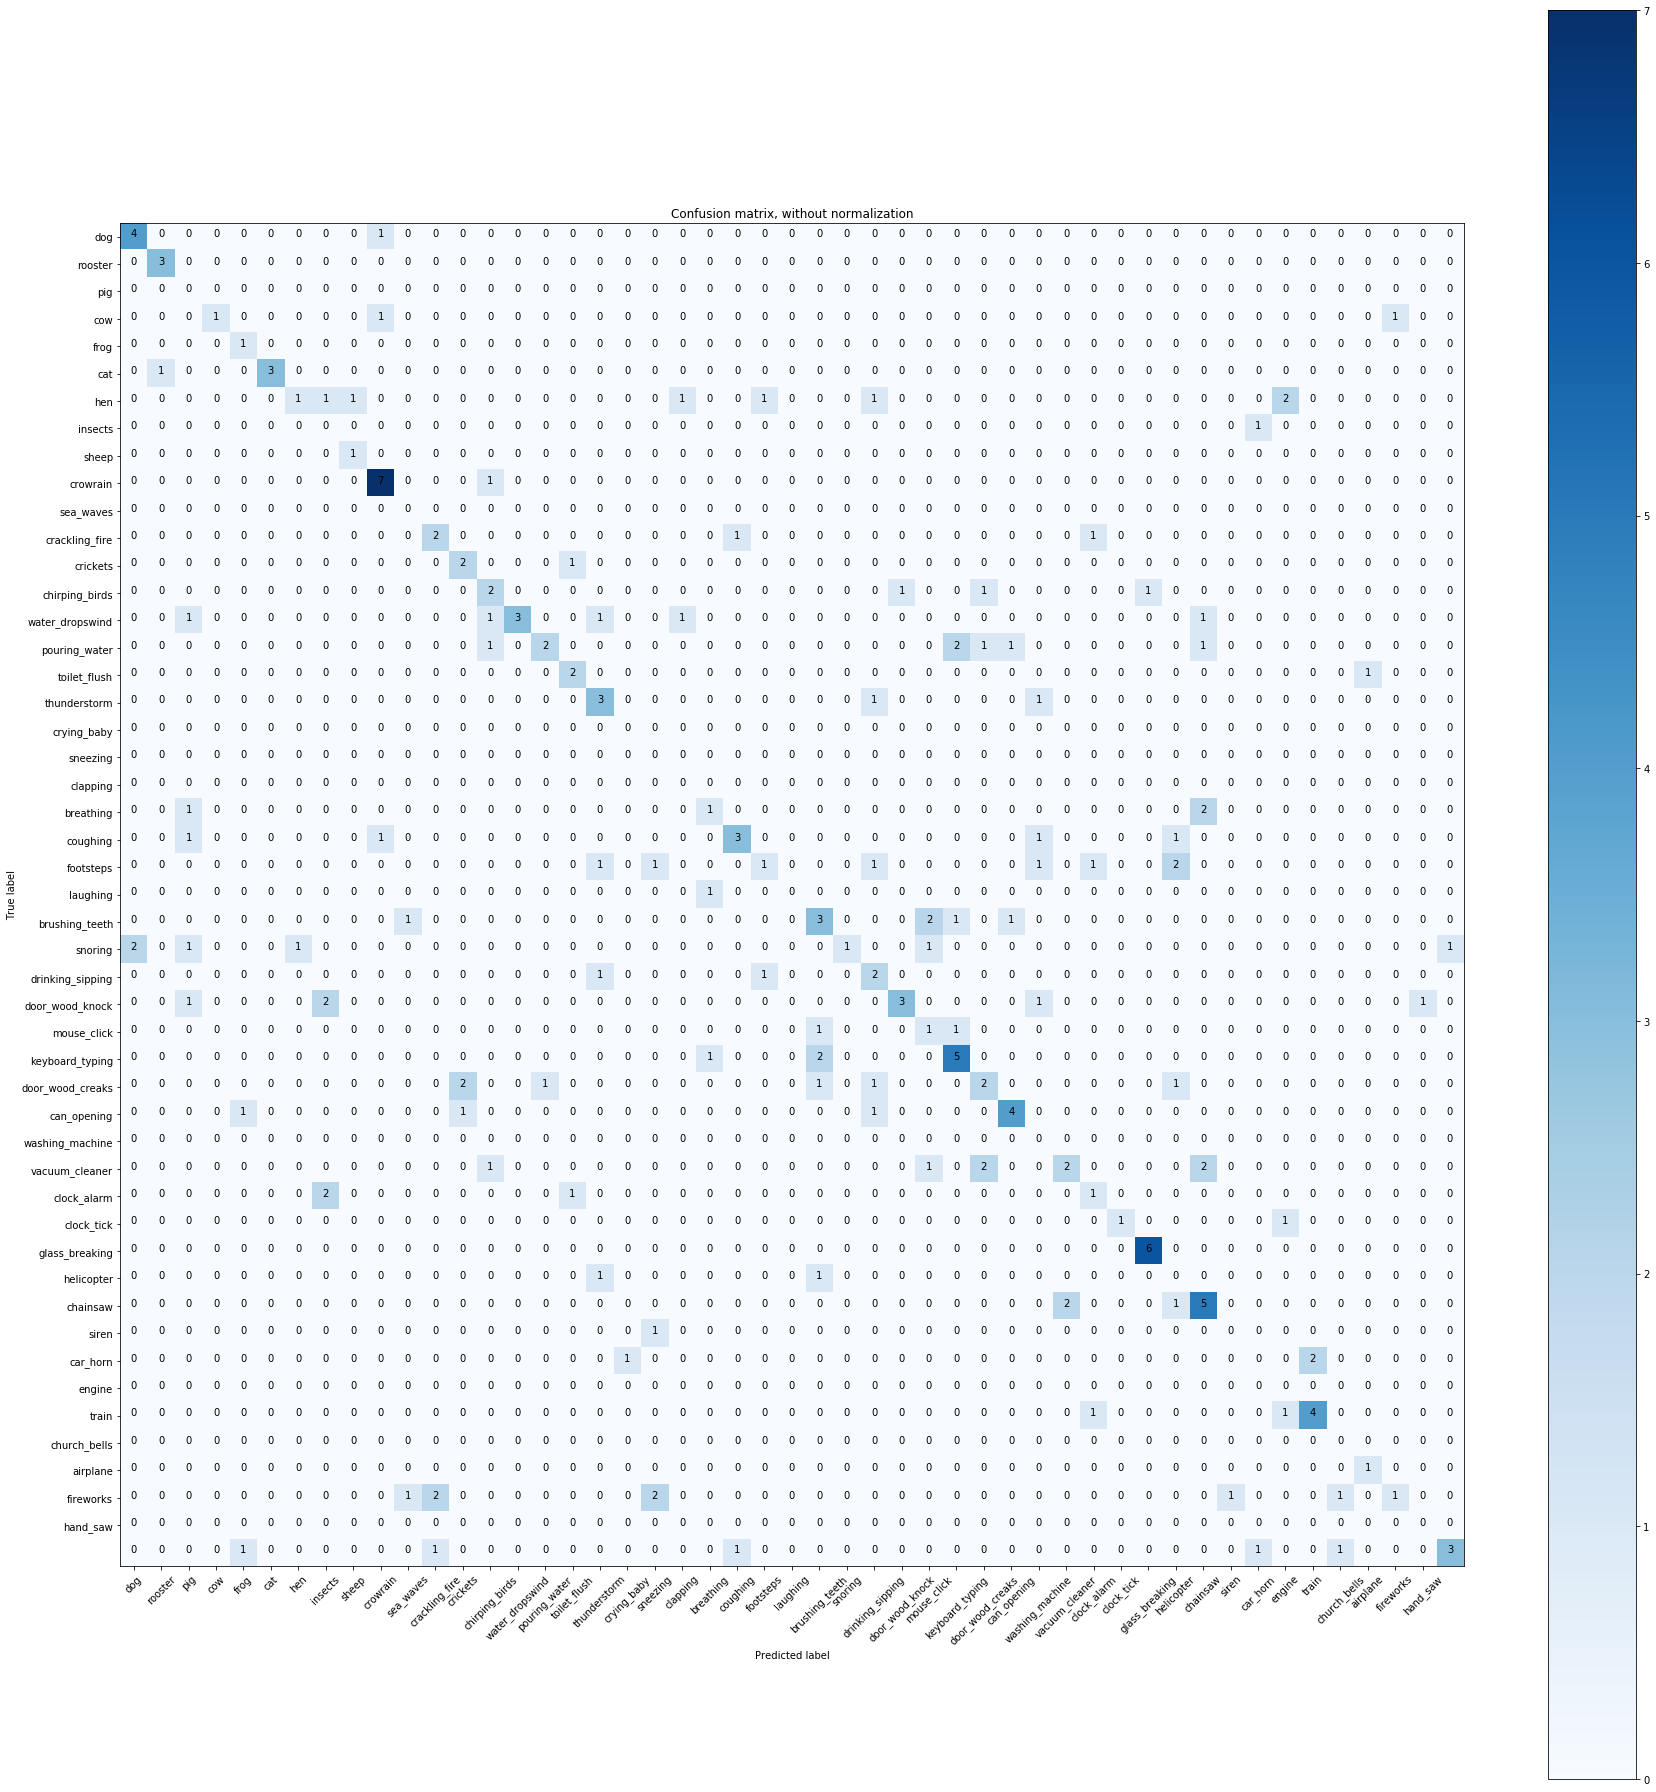

In [52]:
y_pred=np.array([])
y_true=np.array([])
for data in testloader:
        indices, labels = data
        inputs = []
        mfcc_inputs = []
        for j in indices:
            inputs.append(spectograms[j])
            mfcc_inputs.append(mfccs[j])
        inputs = torch.stack(inputs)
        inputs = (inputs.float()).unsqueeze(1)
        mfcc_inputs = torch.stack(mfcc_inputs)
        mfcc_inputs = (mfcc_inputs.float()).unsqueeze(1)
        if use_gpu == True:
            outputs = audioNet(Variable(inputs.cuda()),Variable(mfcc_inputs.cuda()))
        else:
            outputs = audioNet(Variable(inputs),Variable(mfcc_inputs))
        _, predicted = torch.max(outputs.data, 1)
        y_true = np.hstack((y_true,labels.numpy()))
        total += labels.size(0)
        if use_gpu == True:
            predicted = predicted.cpu()
        y_pred = np.hstack((y_pred,predicted.numpy()))
        correct += (predicted == labels).sum()
        
#y_pred = y_pred.numpy()
#y_true = np.ndarray(y_true)
#y_pred = np.asarray(y_pred)

cnf_matrix = metrics.confusion_matrix(y_true,y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(25,25))
plot_confusion_matrix(cnf_matrix,classes=Labels,
                      title='Confusion matrix, without normalization')
plt.show()